<a href="https://colab.research.google.com/github/rjc89/Tutorials/blob/master/seaborn_marathon_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -O https://raw.githubusercontent.com/jakevdp/marathon-data/master/marathon-data.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  836k  100  836k    0     0  2086k      0 --:--:-- --:--:-- --:--:-- 2086k


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style("whitegrid")

In [3]:
data = pd.read_csv('marathon-data.csv')
data.head()

,age,gender,split,final
0,33,M,01:05:38,02:08:51
1,32,M,01:06:26,02:09:28
2,31,M,01:06:49,02:10:42
3,38,M,01:06:16,02:13:45
4,31,M,01:06:32,02:13:59


In [4]:
data.dtypes

age        int64
gender    object
split     object
final     object
dtype: object

In [19]:
def convert_time(s):
  return pd.to_timedelta(s)

data = pd.read_csv('marathon-data.csv',
                   converters={'split':convert_time, 'final':convert_time})
data.head()

,age,gender,split,final
0,33,M,01:05:38,02:08:51
1,32,M,01:06:26,02:09:28
2,31,M,01:06:49,02:10:42
3,38,M,01:06:16,02:13:45
4,31,M,01:06:32,02:13:59


In [17]:
data.dtypes

age                 int64
gender             object
split     timedelta64[ns]
final     timedelta64[ns]
dtype: object

In [20]:
data['split_sec'] = data['split'].astype(int) / 1E9
data['final_sec'] = data['final'].astype(int) / 1E9
data.head()

,age,gender,split,final,split_sec,final_sec
0,33,M,01:05:38,02:08:51,3938.0,7731.0
1,32,M,01:06:26,02:09:28,3986.0,7768.0
2,31,M,01:06:49,02:10:42,4009.0,7842.0
3,38,M,01:06:16,02:13:45,3976.0,8025.0
4,31,M,01:06:32,02:13:59,3992.0,8039.0


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


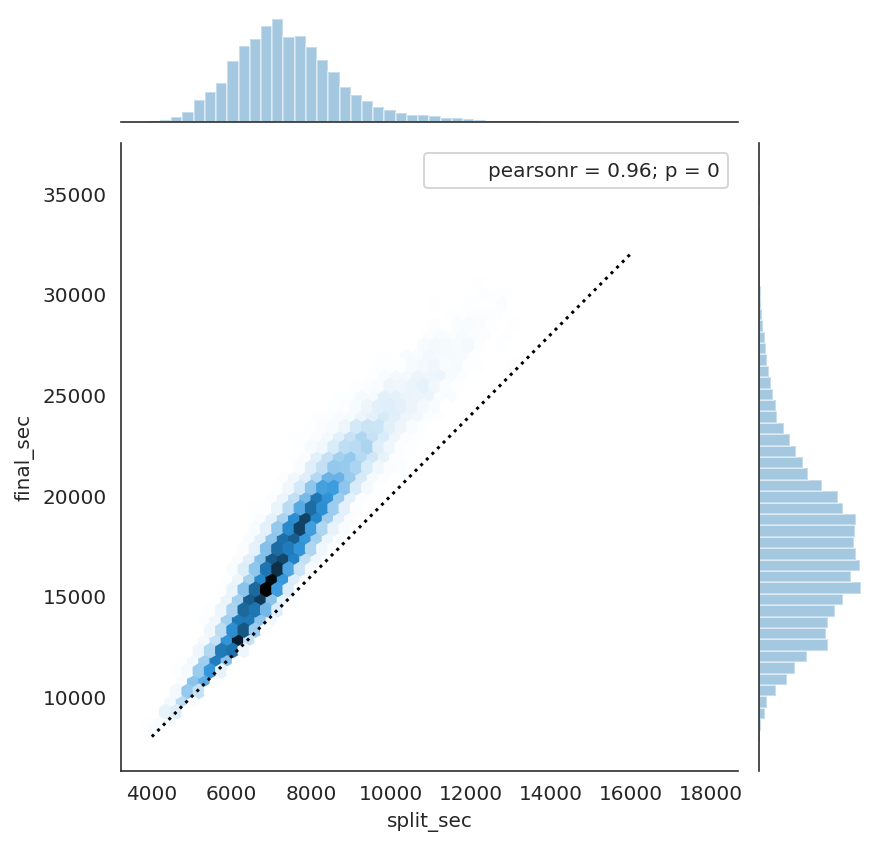

In [25]:
# jointplot over the data in seconds
import scipy.stats as stats

with sns.axes_style('white'):
    g = sns.jointplot("split_sec", "final_sec", data, kind='hex')
    g.ax_joint.plot(np.linspace(4000, 16000), # this adds a equality line
                    np.linspace(8000, 32000), ':k')
    g.annotate(stats.pearsonr); # added a pearsonr annotation (stat_func deprecated)

In [26]:
data['split_frac'] = 1 - 2 * data['split_sec'] / data['final_sec']
data.head()

,age,gender,split,final,split_sec,final_sec,split_frac
0,33,M,01:05:38,02:08:51,3938.0,7731.0,-0.018756
1,32,M,01:06:26,02:09:28,3986.0,7768.0,-0.026262
2,31,M,01:06:49,02:10:42,4009.0,7842.0,-0.022443
3,38,M,01:06:16,02:13:45,3976.0,8025.0,0.009097
4,31,M,01:06:32,02:13:59,3992.0,8039.0,0.006842


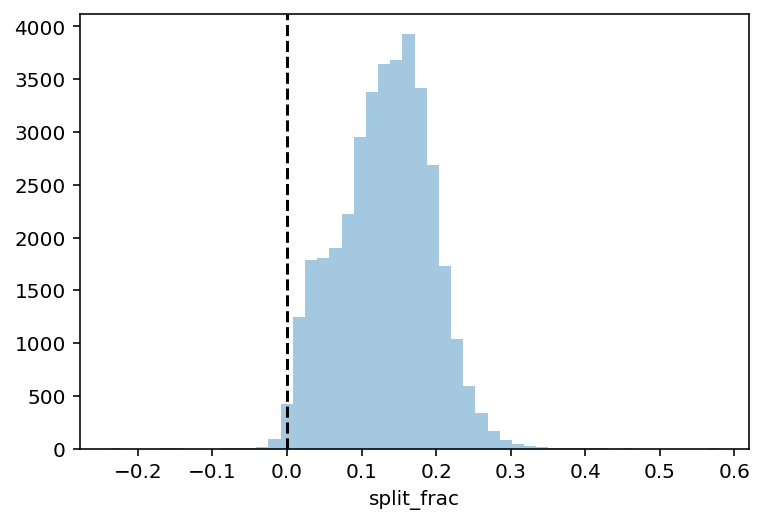

In [27]:
sns.distplot(data['split_frac'], kde=False);
plt.axvline(0, color="k", linestyle="--");

In [28]:
sum(data.split_frac < 0)

251

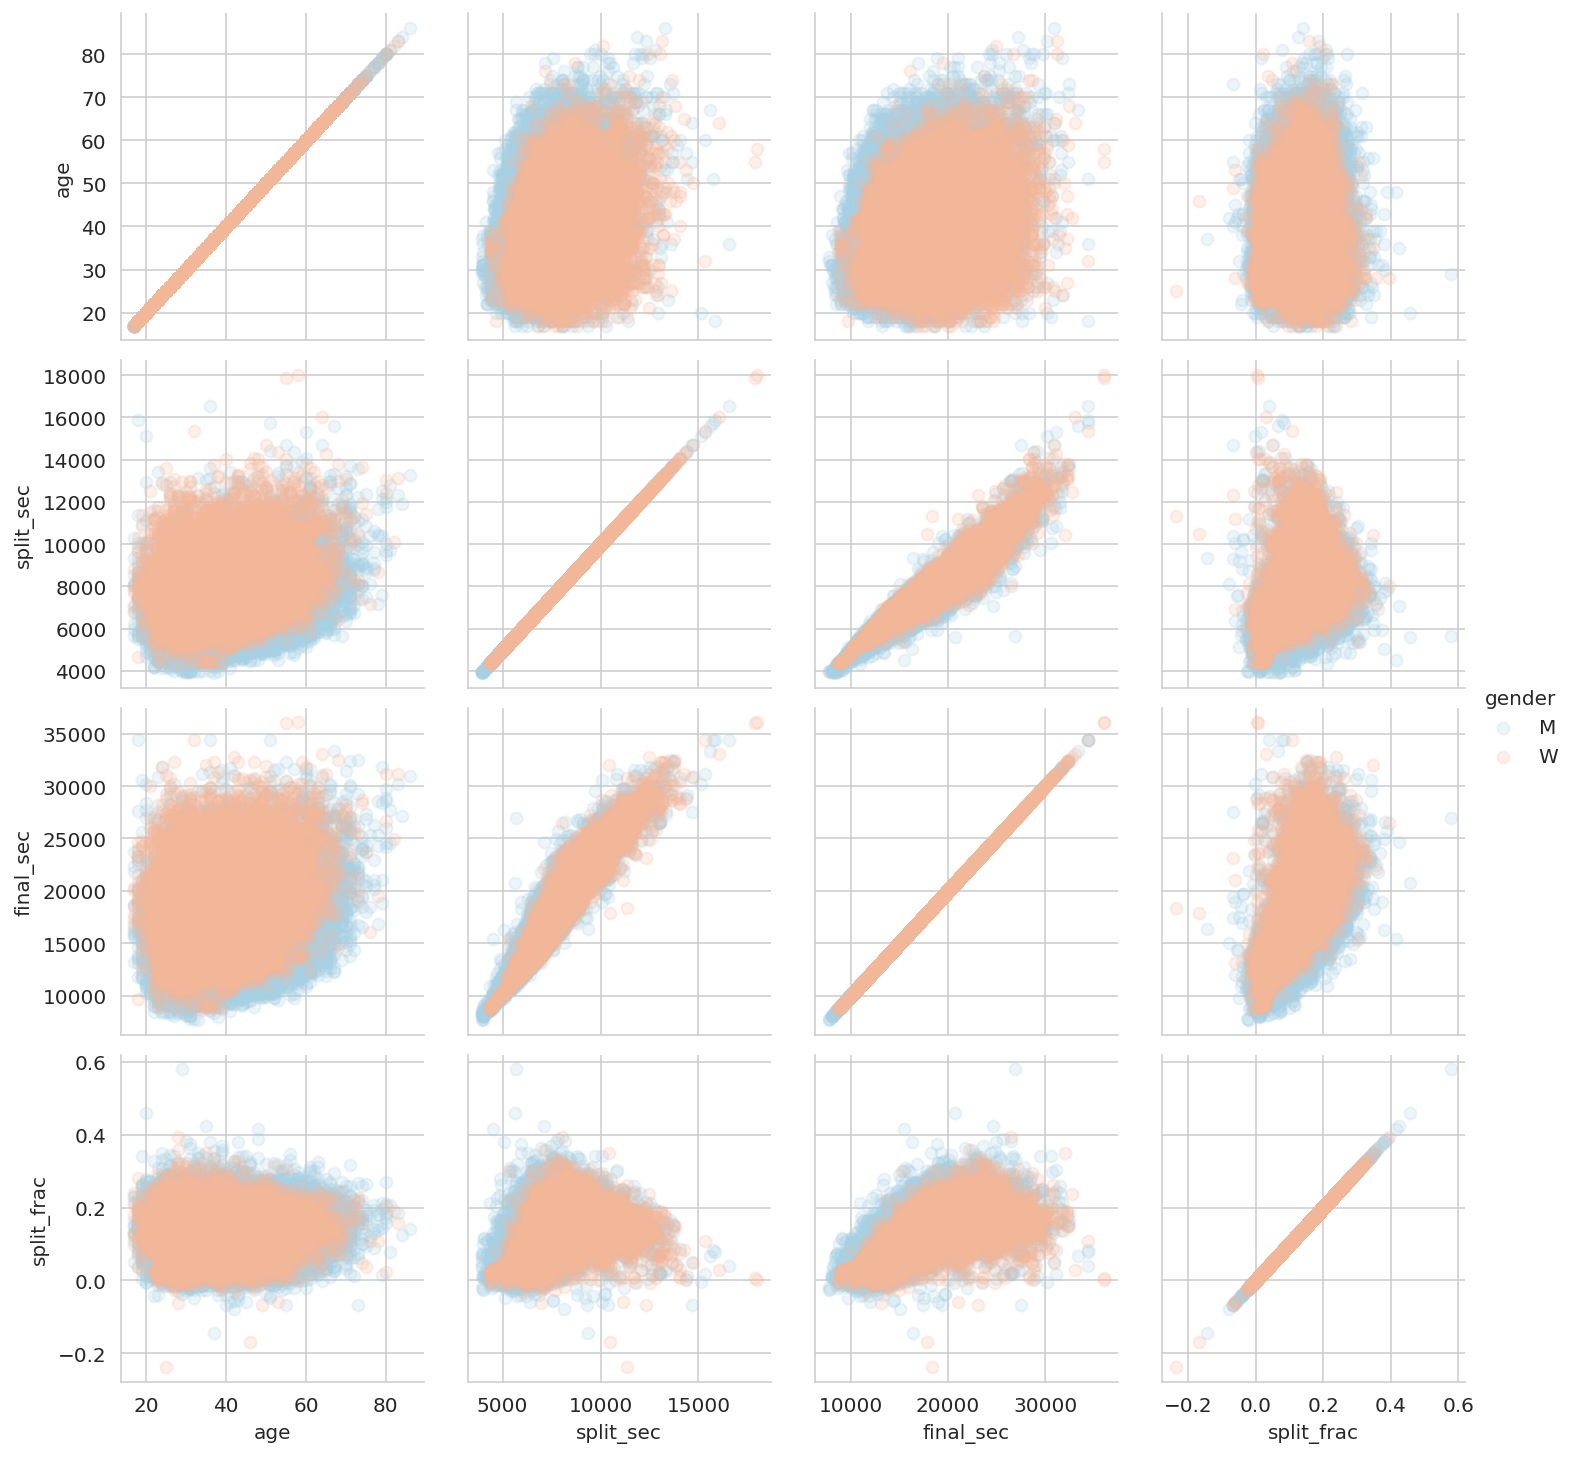

In [34]:
g = sns.PairGrid(data, vars=['age', 'split_sec', 'final_sec', 'split_frac'],
                 hue='gender', palette='RdBu_r')
g.map(plt.scatter, alpha=0.2)
g.add_legend();

- gender differences in split_frac are apparent

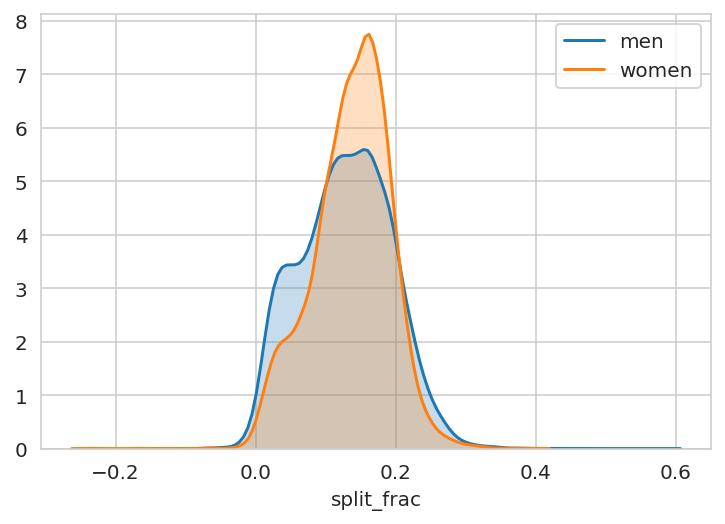

In [38]:
# explore the difference between genders with a kde plot
sns.kdeplot(data.split_frac[data.gender=='M'], label='men', shade=True)
sns.kdeplot(data.split_frac[data.gender=='W'], label='women', shade=True)
plt.xlabel('split_frac');

- more men that women run close to an even split

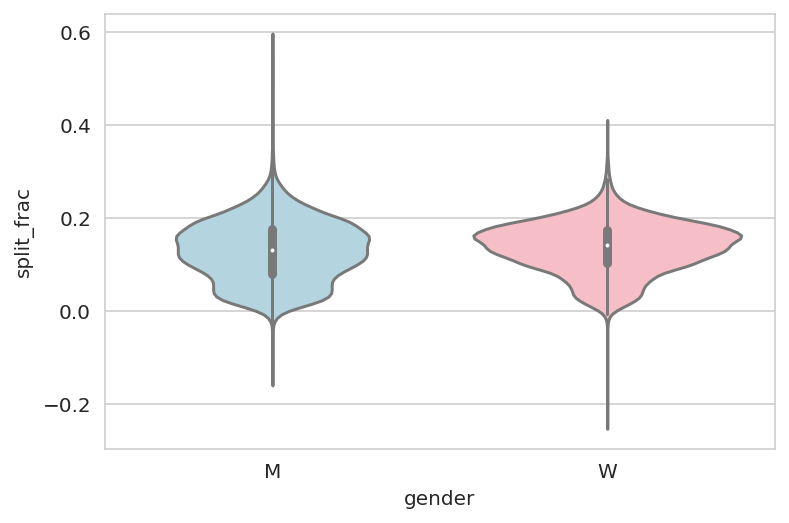

In [39]:
# similarly with the violinplot
sns.violinplot("gender", "split_frac", data=data,
               palette=["lightblue", "lightpink"]);

In [40]:
# what do the split_frac distributions look like for people from each age decade
data['age_dec'] = data.age.map(lambda age: 10 * (age // 10))
data.head()

,age,gender,split,final,split_sec,final_sec,split_frac,age_dec
0,33,M,01:05:38,02:08:51,3938.0,7731.0,-0.018756,30
1,32,M,01:06:26,02:09:28,3986.0,7768.0,-0.026262,30
2,31,M,01:06:49,02:10:42,4009.0,7842.0,-0.022443,30
3,38,M,01:06:16,02:13:45,3976.0,8025.0,0.009097,30
4,31,M,01:06:32,02:13:59,3992.0,8039.0,0.006842,30


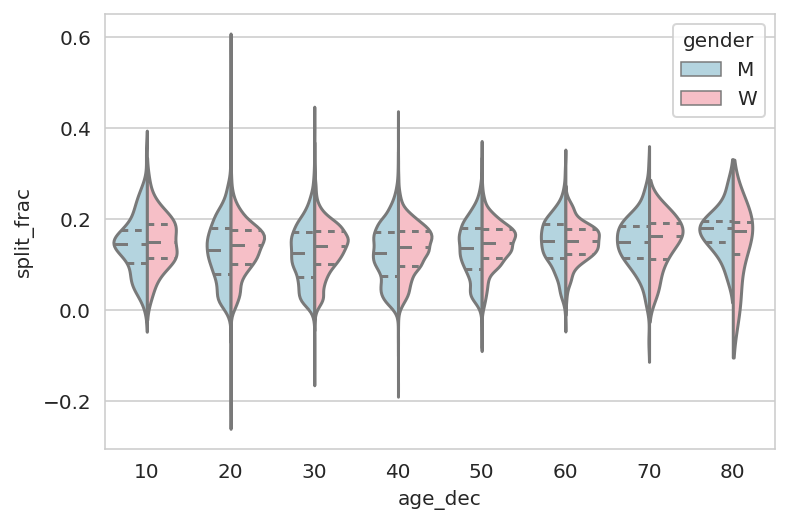

In [41]:
men = (data.gender == 'M')
women = (data.gender == 'W')

with sns.axes_style(style=None):
    sns.violinplot("age_dec", "split_frac", hue="gender", data=data,
                   split=True, inner="quartile",
                   palette=["lightblue", "lightpink"]);

- 20 to 50 yo men have more density towards lower split_fracs

- 80 yo women also have great split_frac distributions (we're estimating the distribution from a smaller sample size)

In [42]:
(data.age > 80).sum()

7

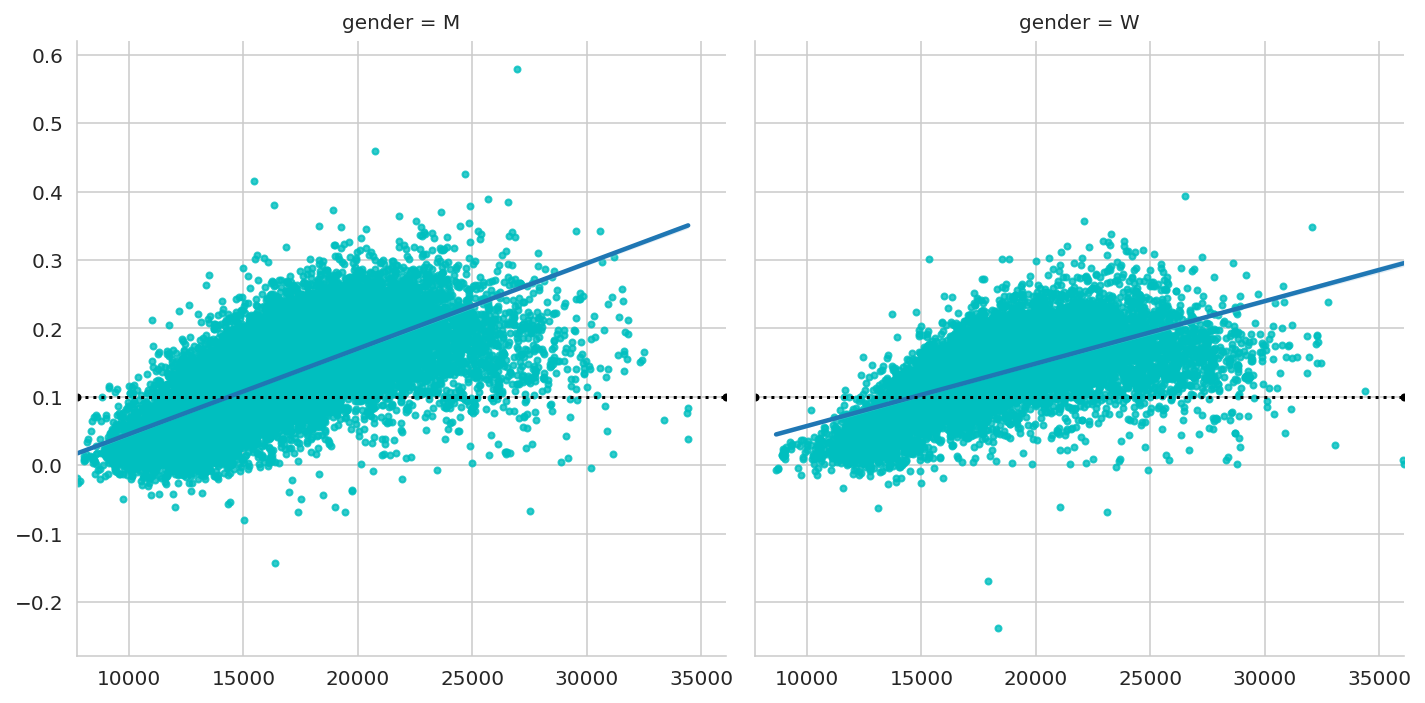

In [43]:
# lmplot (linear model plot?) scatter plot with linear regression line
g = sns.lmplot('final_sec', 'split_frac', col='gender', data=data,
               markers=".", scatter_kws=dict(color='c'))
g.map(plt.axhline, y=0.1, color="k", ls=":");